# Applied Machine learning !

In this lab we will study a soccer dataset and apply Machine Learning to it. We will try to predict the skin color of a player given some of it's information.

### Some useful imports

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from sklearn import metrics
from sklearn.preprocessing import binarize, normalize, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from helpers import *
from scipy.stats import uniform
pylab.rcParams['figure.figsize'] = (16, 6)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First we import the dataset and study it :

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

How much data do we have ?

In [3]:
df.shape

(146028, 28)

Let's look at our columns.

In [4]:
df.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
df.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


There are two different skin-color (from white to black) raters, that agree on percentage:

In [6]:
np.count_nonzero(df.rater1 == df.rater2) / len(df)

0.6554496397951078

Thanks to the previous [work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) of Mat Evans and Tom Stafford and their team. We know some of the specificities of the data, namely:
- We learn that the data is organized in a player-referee pairs (dyads). Each row has all the interaction with one player and a referee. For their analysis they decided to separate this dataset for each interaction between a player and a referee. Our approach will rather group by player short to keep the player granularity as central point.
- The data about skin color is not consistent between the two raters and the picture might be missing. We decided to remove the data with no picture as it cannot help to answer "given a soccer player description outputs his skin color". There are different ways to attribute skin color to each player :
    - mean of the two raters
    - keep only the dyads which have the same score for r1 and r2
    - train on both raters and compare the result
- The raters data in the set [0, 0.25, 0.50, 0.75, 1] to classify "correctly" there are 3 possibilities :
    - first one is to have a class for each number
    - second is to have two classes with a cut at 0.5 (we have to define which class contain 0.5)
    - third is to have 3 classes : $<0.5$, $0.5$, $>0.5$
- Finally we learn that there are dyads which are not really part of the 2012-2013 data but from past matches in the carrer of the player. Either remove thoses entires because their not really part of the dataset "topic" or let them as their could give more insights. We decided to remove them.

Here is how we think of organizing this homework :
- First we will clean a bit the data
- Then we will aggregate the data per player
- Then we will for each point made above with multiple proposition see which one is the best, if multiple ones seem good we will keep them and test them with cross validation.
- Finally we will find the best result we can with all possible datasets with a random forest classifier.

## Removing non valid dyads from player past history

To remove those dyad, the logic is to say that if a referee has participated in at least one match in the league he should have at least 22 appearances in the dataset.

In [7]:
dyads_b = df.shape[0]
games_b = df.games.sum()
referee_b = df.refNum.unique().shape[0]
print("number of dyads before cleaning : ", dyads_b)
print("number of matches before cleaning : ", games_b)
print("number of unique referee before cleaning : ", referee_b)

number of dyads before cleaning :  146028
number of matches before cleaning :  426572
number of unique referee before cleaning :  3147


Using cited work number for comparison, after cleaning they got:

In [8]:
games_a_tot = 415692
dyads_a_tot = 137635
referee_a_tot = 1261

Our method (group by player short):

In [9]:
apearances_once_player = df.refNum.value_counts()
len(apearances_once_player)

3147

In [10]:
apearances_sup21_once_player = apearances_once_player[apearances_once_player >= 22]
df_sup21_once_player = df[df["refNum"].isin(apearances_sup21_once_player.index.values)]

In [11]:
dyads_a_once_player = df_sup21_once_player.shape[0]
games_a_once_player = df_sup21_once_player.games.sum()
referee_a_once_player = df_sup21_once_player["refNum"].unique().shape[0]
print("number of dyads after removing : ", dyads_a_once_player)
print("number of matches after removing : ", games_a_once_player) # a bit lower than before again
print("number of unique referee after removing : ", referee_a_once_player)

number of dyads after removing :  133501
number of matches after removing :  406924
number of unique referee after removing :  998


Let's show how much data we lose

In [12]:
print("loss of games with their method :", games_a_tot / games_b)
print("loss of dyads with their method :", dyads_a_tot / dyads_b)
print("loss of refs with their method : ", referee_a_tot / referee_b)

loss of games with their method : 0.974494340932
loss of dyads with their method : 0.9425247212863287
loss of refs with their method :  0.40069907848744835


In [13]:
print("loss of games with our method :", games_a_once_player / games_b)
print("loss of dyads with our method :", dyads_a_once_player / dyads_b)
print("loss of refs with our method : ", referee_a_once_player / referee_b)

loss of games with our method : 0.953939780389
loss of dyads with our method : 0.914215082039061
loss of refs with our method :  0.3171274229424849


We lost a bit more data but it will be more convient to use later. Let's check using the same kind of occurences graph.

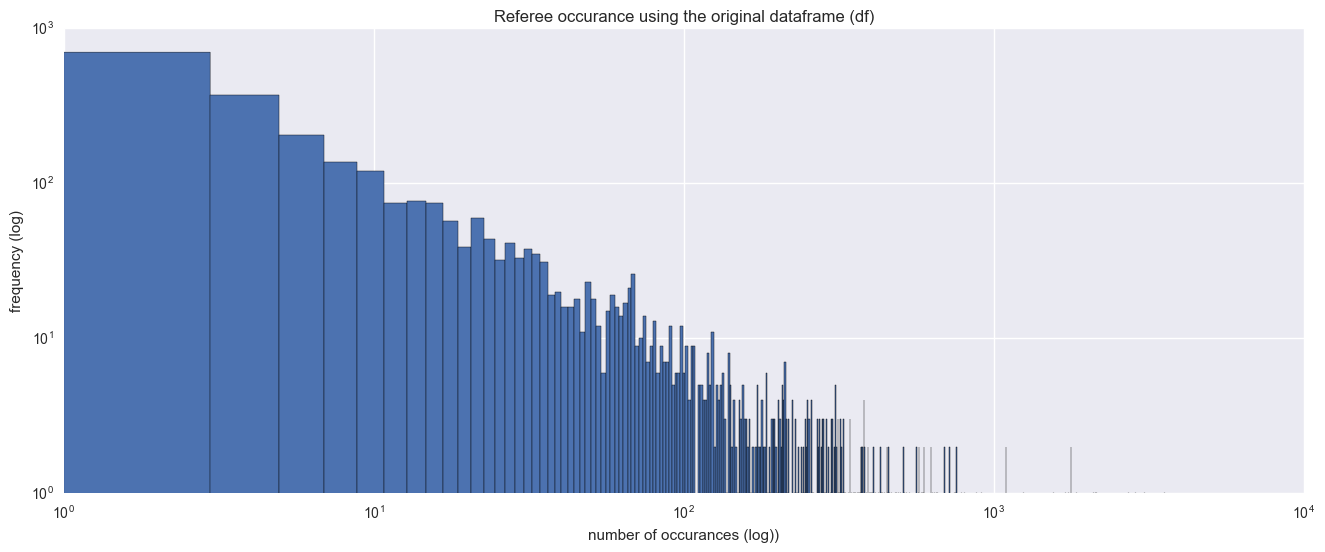

In [14]:
plt.hist(df[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the original dataframe (df)")
plt.show()

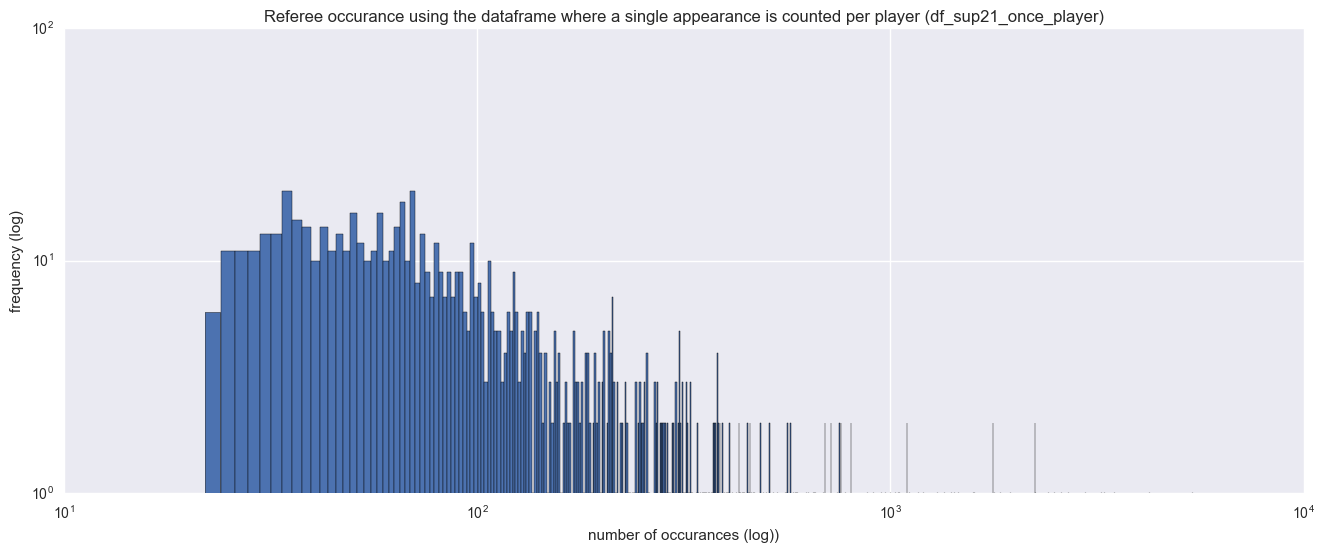

In [15]:
plt.hist(df_sup21_once_player[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the dataframe where a single appearance is counted per player (df_sup21_once_player)")
plt.show()

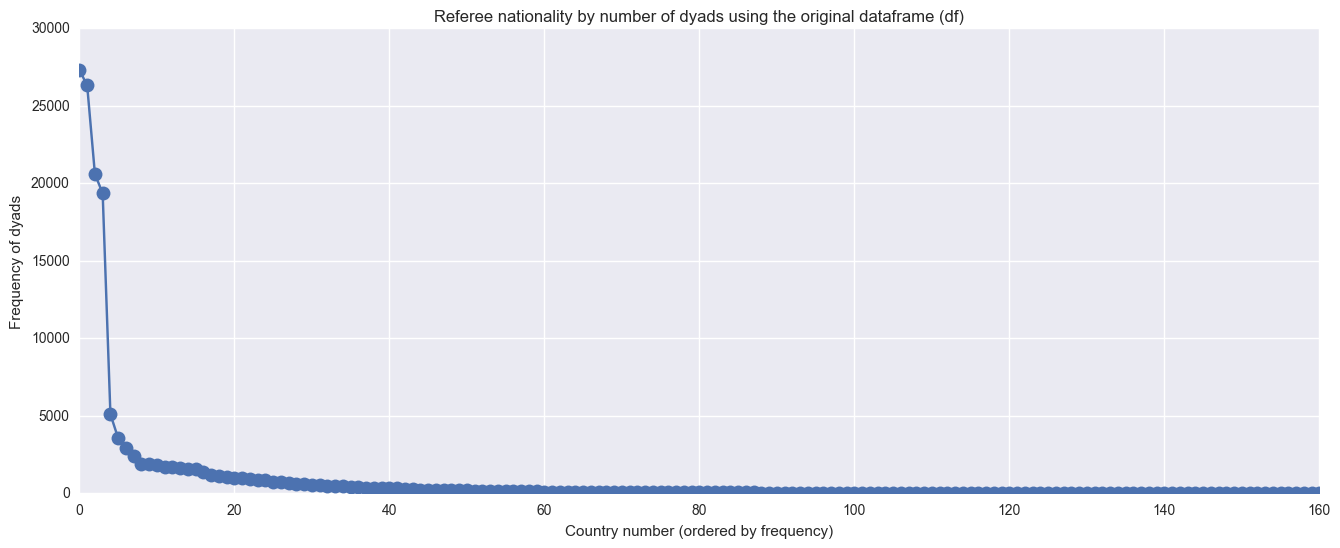

In [16]:
x = df.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the original dataframe (df)')
plt.xlabel('Country number (ordered by frequency)')
plt.ylabel('Frequency of dyads')
plt.show()

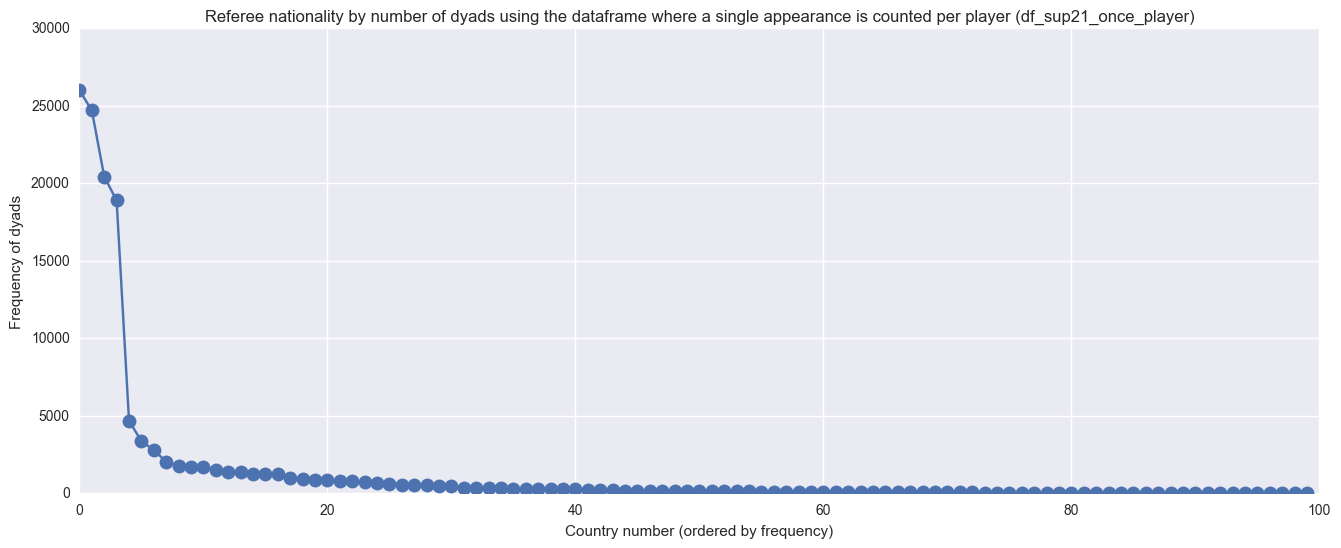

In [17]:
x = df_sup21_once_player.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the dataframe where a single appearance is counted per player (df_sup21_once_player)')
plt.xlabel('Country number (ordered by frequency)')
plt.ylabel('Frequency of dyads')
plt.show()

Here we see that our method reduces the number of total countries but doesn't change the frequency of dyads with the most represented countries compared to the previous graph.

## Removing non usable data for our ML algorithm

We know sometimes there is no images for a player and therefor no skin color rating. Therefore we remove them.

In [18]:
df_with_pic = df_sup21_once_player[df_sup21_once_player["photoID"].notnull()]

In [19]:
df_sup21_once_player.shape[0]

133501

In [20]:
df_with_pic.shape[0]

113862

Should be all clean now.

In [21]:
dfc = df_with_pic

## Aggregating the data by player

Let's look at a single players dyad to have an idea of what it looks like

In [23]:
groups = dfc.groupby("playerShort")

In [24]:
lucas = groups.get_group("lucas-wilchez")

In [25]:
lucas.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
2782,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,3,1,1,1,0
3384,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
5692,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,1,0,0,0
9058,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,2,2,0,0,0
14886,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,1,0,0


In [26]:
lucas.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
2782,0,0,0,95212.jpg,0.25,0.5,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3384,0,0,0,95212.jpg,0.25,0.5,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5692,0,0,0,95212.jpg,0.25,0.5,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
9058,1,0,0,95212.jpg,0.25,0.5,214,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
14886,0,0,0,95212.jpg,0.25,0.5,313,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696


First we will only keep the columns that seem relevant to us and remove the ones we think are not important :
- `player` which is a repetition of the playershort
- `photoID` which is 1-to-1 with the player
- referee related attibute which cannot be aggregated (`refNum`, `refCountry`, `Alpha3`)
- `nIAT` and `nExp` really not relevant here we could do a weihted mean with the "mean" and "se" columns but it seemed a bit exagerated (futur improvement ?)
    
Why we kept other columns is explained below with the aggregation operation.

In [27]:
df_byshort = dfc.groupby("playerShort")
df_grouped = df_byshort.agg({
        "club": lambda x: x.unique()[0],
        "leagueCountry": lambda x: x.unique()[0],
        "birthday": lambda x: x.unique()[0],
        "height": np.max,
        "weight": np.max,
        "position": lambda x: x.unique()[0],
        "games": np.sum,
        "victories": np.sum,
        "ties": np.sum,
        "defeats": np.sum,
        "goals": np.sum,
        "yellowCards": np.sum,
        "yellowReds": np.sum,
        "redCards": np.sum,
        "rater1": np.max, # never changes so we can take either min, max or mean 
        "rater2": np.max, # same here (we used this to test that nothing changed : [np.min, np.max, np,mean])
        "meanIAT": np.mean, # Here doing the mean seems a bit confusing but it will give an 
        "seIAT": np.mean,   # indicatiion whether the player could have been mistreated in 
                            # some of his matches or never.
        "meanExp": np.mean, # Same here
        "seExp": np.mean    # We could have applied pooled variance (will see later) : https://en.wikipedia.org/wiki/Pooled_variance
    })

In [28]:
# We used this to check wether min and max rating change for each player (which was not the case)
np.count_nonzero(df_byshort.agg({"rater1": np.min}) != df_byshort.agg({"rater1": np.max}))

0

In [29]:
np.count_nonzero(df_byshort.agg({"rater2": np.min}) != df_byshort.agg({"rater2": np.max}))

0

In [30]:
np.count_nonzero(df_byshort.agg({"position": lambda x: x.unique().shape[0]}) > 1)

0

In [31]:
np.count_nonzero(df_byshort.agg({"leagueCountry": lambda x: x.unique().shape[0]}) > 1)

0

In [32]:
np.count_nonzero(df_byshort.agg({"club": lambda x: x.unique().shape[0]}) > 1)

0

In [33]:
np.count_nonzero(df_byshort.agg({"birthday": lambda x: x.unique().shape[0]}) > 1)

0

In [39]:
df_grouped.head().ix[:,:13]

,yellowReds,rater2,goals,defeats,leagueCountry,weight,club,position,redCards,seExp,seIAT,ties,meanExp
playerShort,,,,,,,,,,,,,
aaron-hughes,0,0.00,9,222,England,71.0,Fulham FC,Center Back,0,0.001553,0.000333,176,0.487879
aaron-hunt,0,0.25,59,119,Germany,73.0,Werder Bremen,Attacking Midfielder,1,0.001025,0.000226,70,0.453989
aaron-lennon,0,0.25,31,115,England,63.0,Tottenham Hotspur,Right Midfielder,0,0.002032,0.000367,97,0.491482
aaron-ramsey,0,0.00,39,67,England,76.0,Arsenal FC,Center Midfielder,1,0.002938,0.000525,42,0.511650
abdelhamid-el-kaoutari,4,0.25,1,43,France,73.0,Montpellier HSC,Center Back,2,0.005296,0.001488,40,0.335587


In [40]:
df_grouped.head().ix[:,13:]

,yellowCards,birthday,victories,games,height,rater1,meanIAT
playerShort,,,,,,,
aaron-hughes,19,08.11.1979,243,641,182.0,0.25,0.344759
aaron-hunt,39,04.09.1986,140,329,183.0,0.00,0.349332
aaron-lennon,11,16.04.1987,200,412,165.0,0.25,0.345893
aaron-ramsey,31,26.12.1990,145,254,178.0,0.00,0.346790
abdelhamid-el-kaoutari,8,17.03.1990,41,124,180.0,0.25,0.331600


In [41]:
len(df_grouped)

1584

Thanks to the description of the data in DATA.md we know there should be 1586 players with pictures.
With this value we can validate the fact that we lost minimal data and have most of the players with a picture.

## Preparing Data

As a last step before starting to do machine learning we need to reformat the data and seperate it

First we need to make rows which contain strings in integers (club, position, leagueCountry)

In [42]:
df_grouped["club"] = df_grouped["club"].astype(np.str)
df_grouped["position"] = df_grouped["position"].astype(np.str)
df_grouped["leagueCountry"] = df_grouped["leagueCountry"].astype(np.str)

def encodeLabels(col, df):
    le = LabelEncoder()
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

encodeLabels("club", df_grouped)
encodeLabels("position", df_grouped)
encodeLabels("leagueCountry", df_grouped)
encodeLabels("birthday", df_grouped)

Now we can create the futur x and y for training

In [43]:
y_possible = df_grouped[["rater1","rater2"]]
y_possible.head()

,rater1,rater2
playerShort,,
aaron-hughes,0.25,0.00
aaron-hunt,0.00,0.25
aaron-lennon,0.25,0.25
aaron-ramsey,0.00,0.00
abdelhamid-el-kaoutari,0.25,0.25


In [44]:
x = df_grouped.drop(y_possible, axis=1)
x.head().ix[:,:13]

,yellowReds,goals,defeats,leagueCountry,weight,club,position,redCards,seExp,seIAT,ties,meanExp,yellowCards
playerShort,,,,,,,,,,,,,
aaron-hughes,0,9,222,0,71.0,34,1,0,0.001553,0.000333,176,0.487879,19
aaron-hunt,0,59,119,2,73.0,90,0,1,0.001025,0.000226,70,0.453989,39
aaron-lennon,0,31,115,0,63.0,82,10,0,0.002032,0.000367,97,0.491482,11
aaron-ramsey,0,39,67,0,76.0,6,3,1,0.002938,0.000525,42,0.511650,31
abdelhamid-el-kaoutari,4,1,43,1,73.0,51,1,2,0.005296,0.001488,40,0.335587,8


In [45]:
x.head().ix[:,13:]

,birthday,victories,games,height,meanIAT
playerShort,,,,,
aaron-hughes,360,243,641,182.0,0.344759
aaron-hunt,176,140,329,183.0,0.349332
aaron-lennon,719,200,412,165.0,0.345893
aaron-ramsey,1198,145,254,178.0,0.346790
abdelhamid-el-kaoutari,758,41,124,180.0,0.331600


In [46]:
def prepFeature(feature) :
    nans = True in x[feature].isnull().unique()
    
    if nans:
        print("mean replacement of nans")
        x[feature] = x[feature].fillna(int(x[feature].mean()))
    
    plt.title("histogram of feature " + feature)
    plt.hist(x[feature].values)

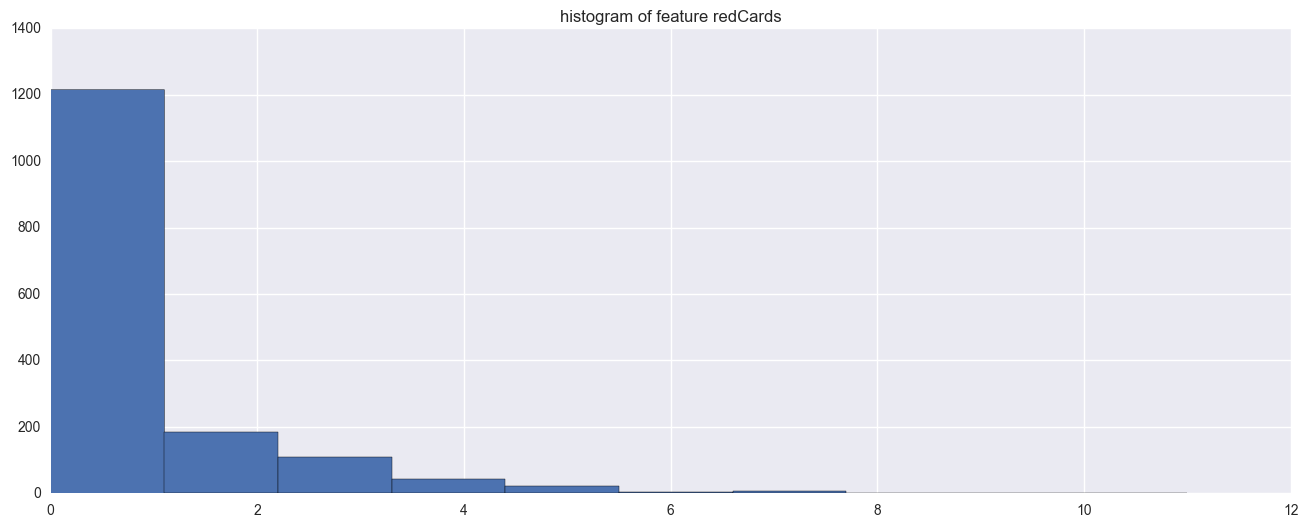

In [47]:
prepFeature("redCards")

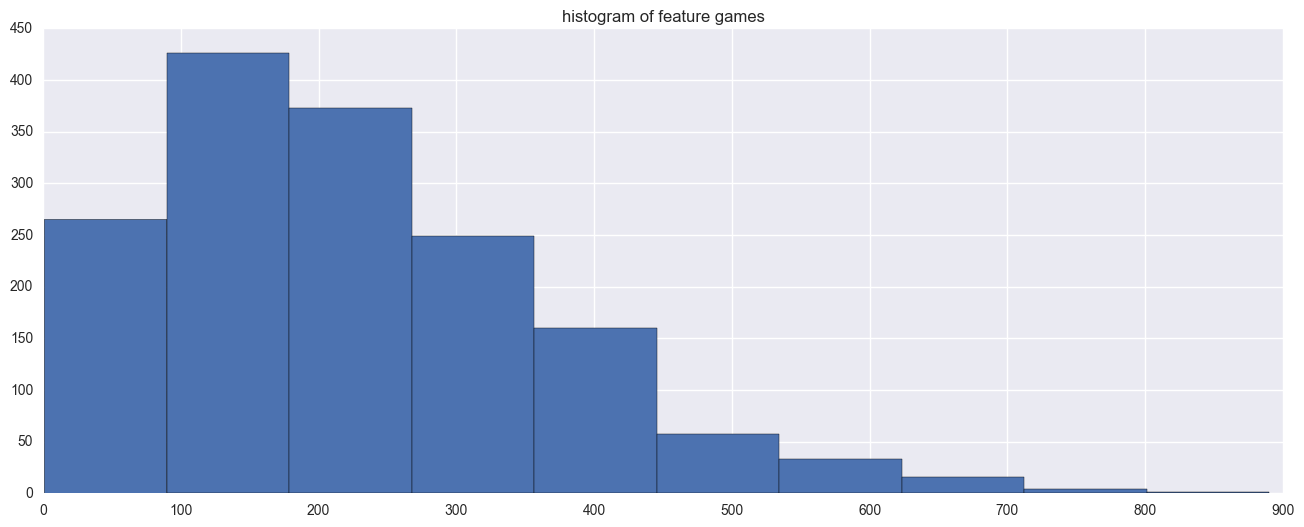

In [48]:
prepFeature("games")

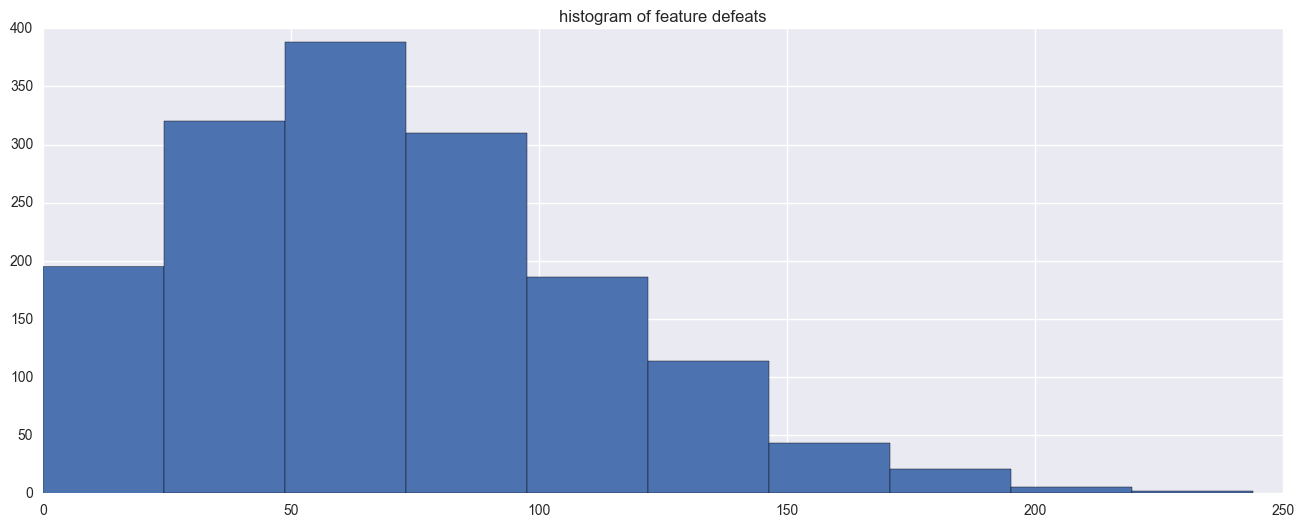

In [49]:
prepFeature("defeats")

mean replacement of nans


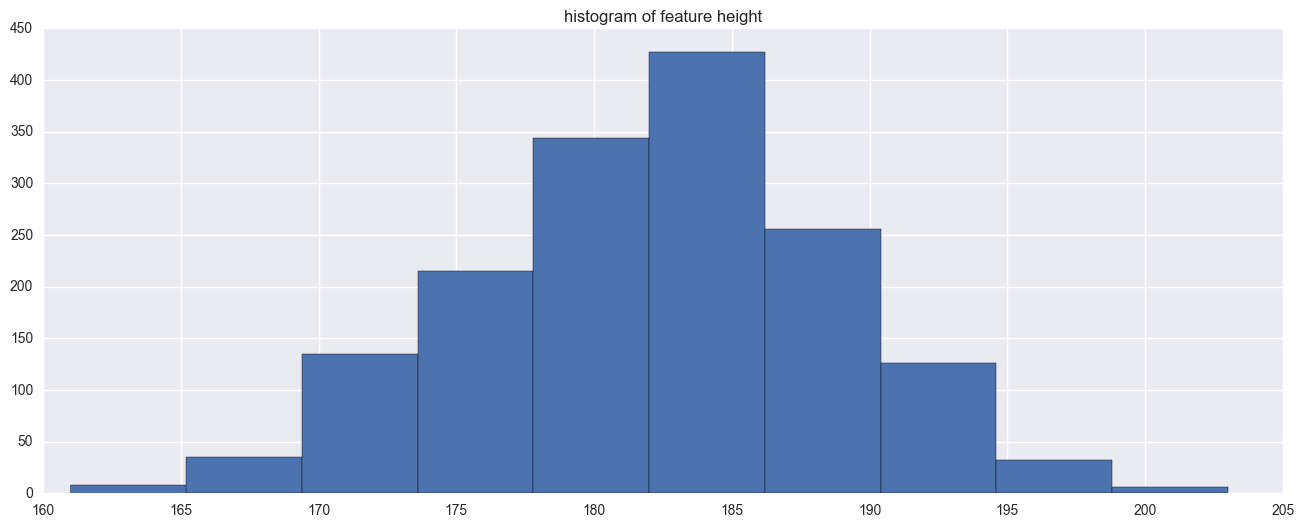

In [50]:
prepFeature("height")

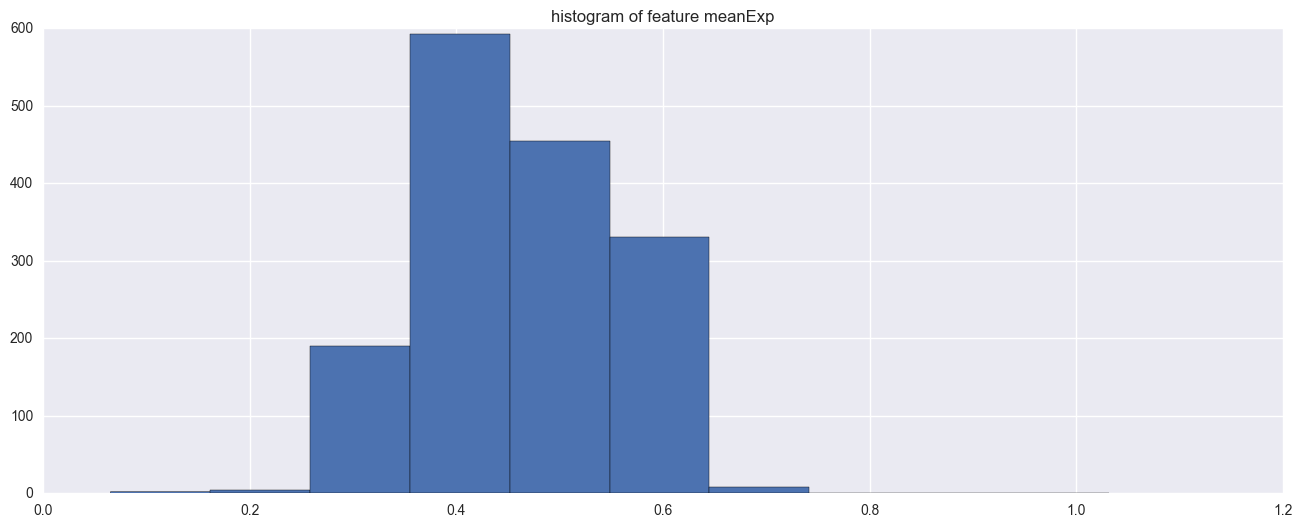

In [51]:
prepFeature("meanExp")

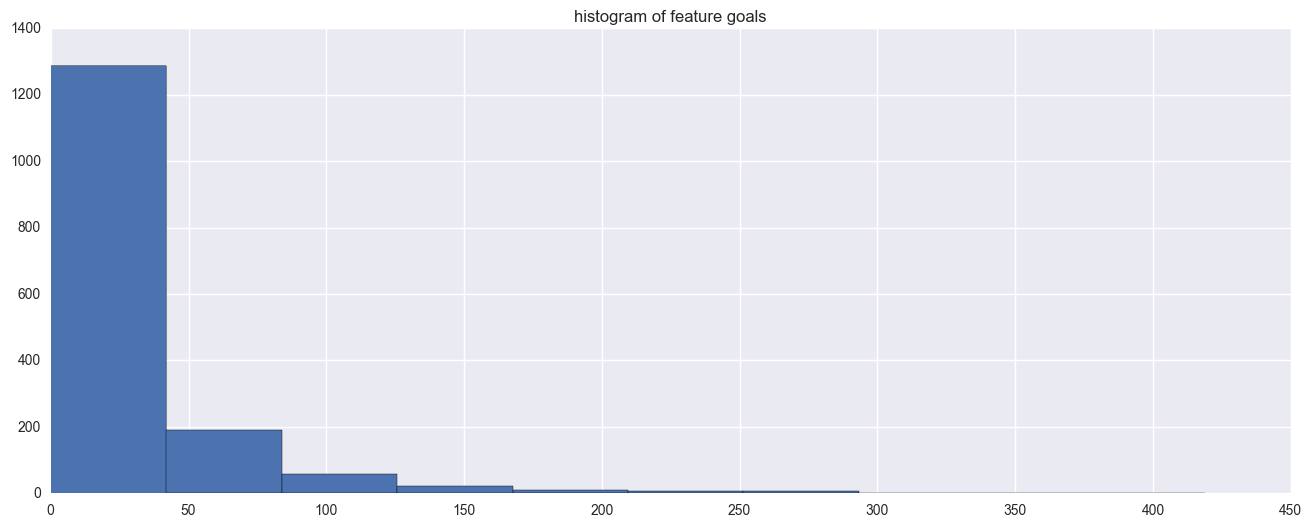

In [52]:
prepFeature("goals")

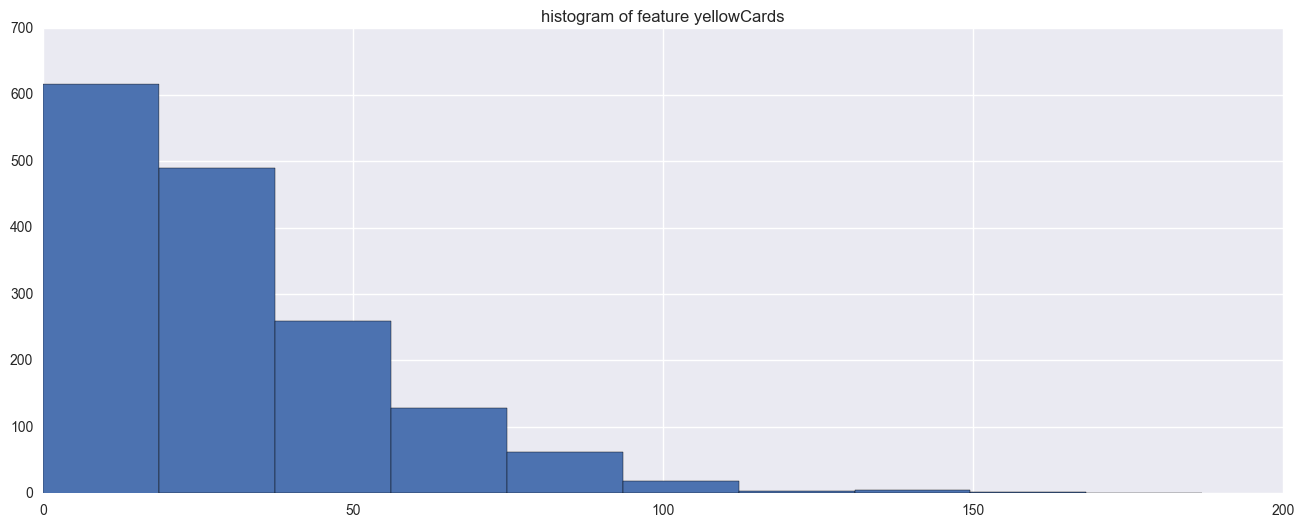

In [53]:
prepFeature("yellowCards")

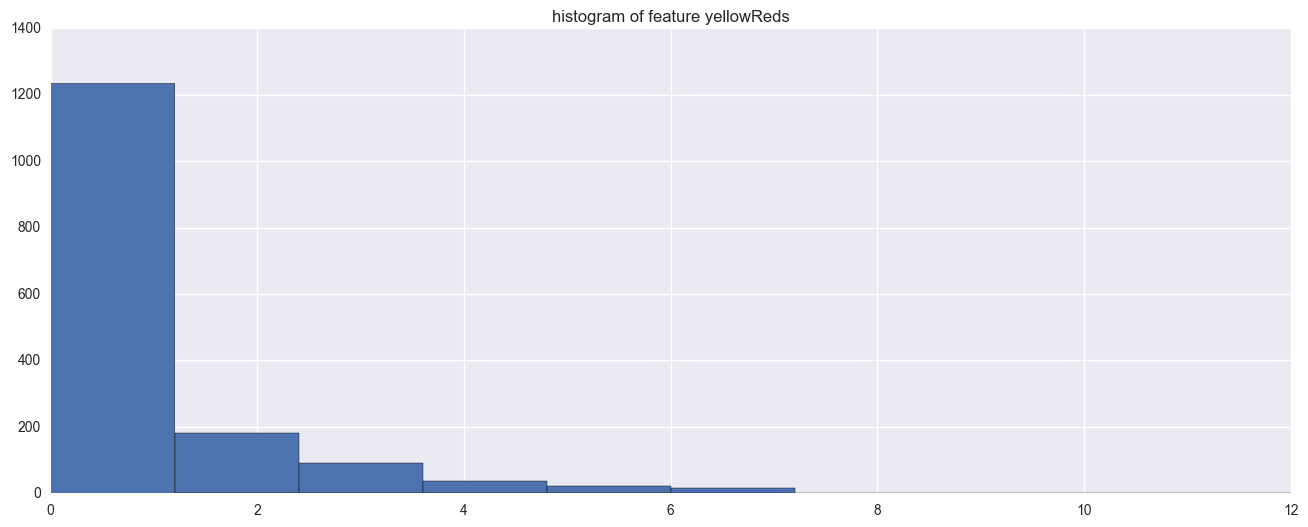

In [54]:
prepFeature("yellowReds")

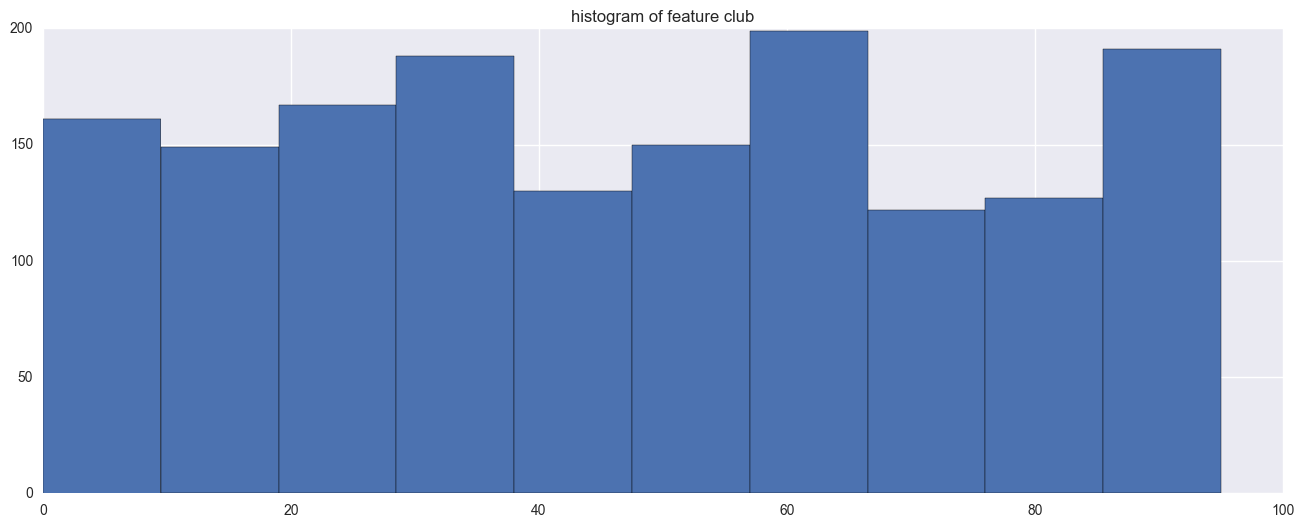

In [55]:
prepFeature("club")

mean replacement of nans


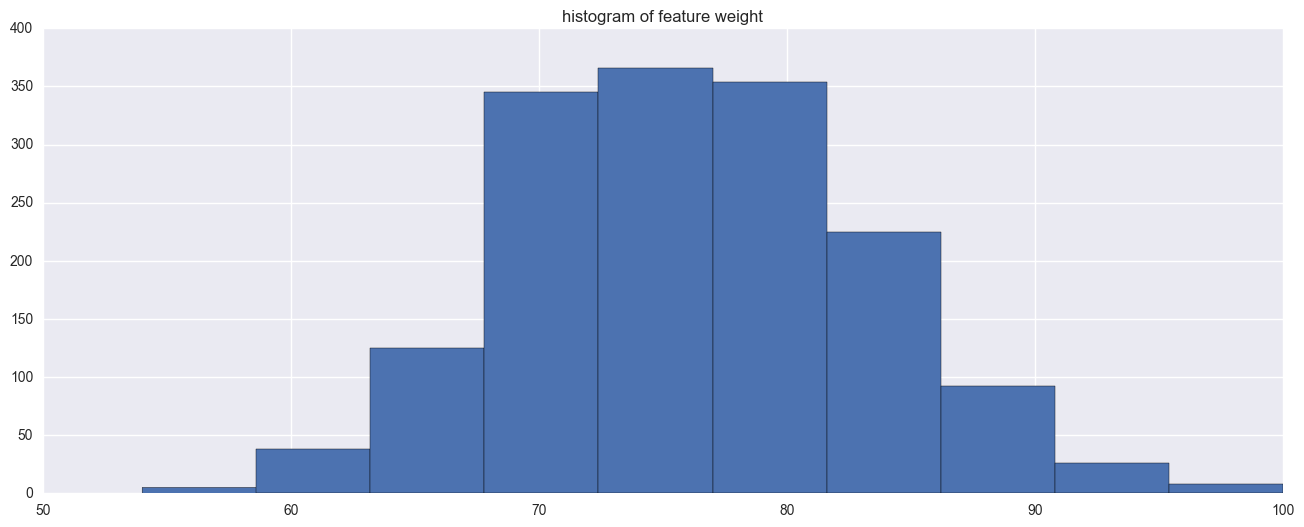

In [56]:
prepFeature("weight")

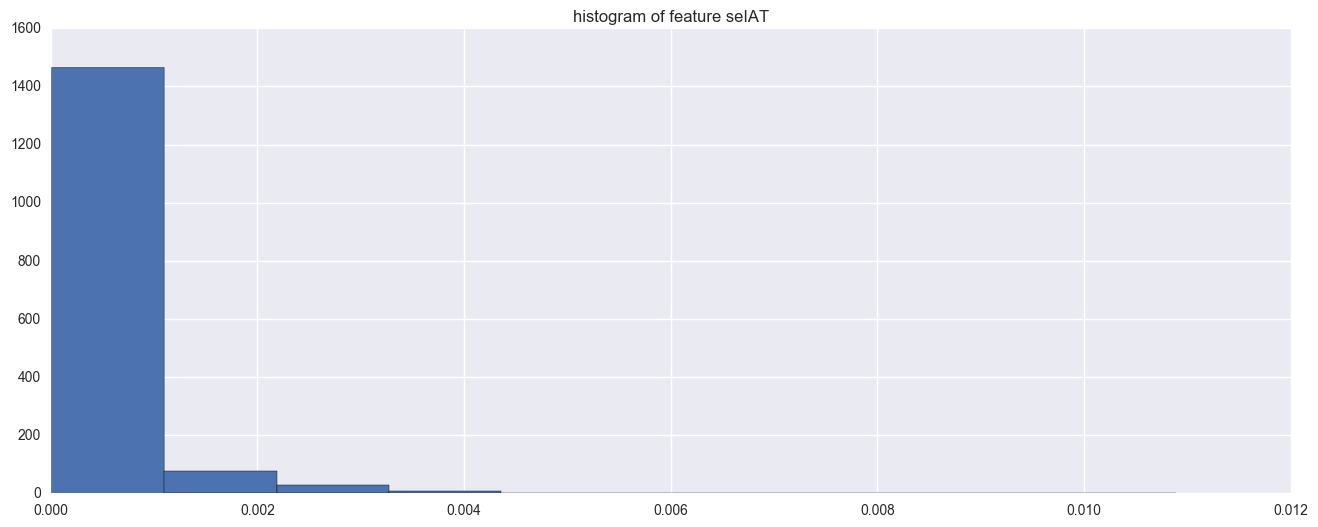

In [57]:
prepFeature("seIAT")

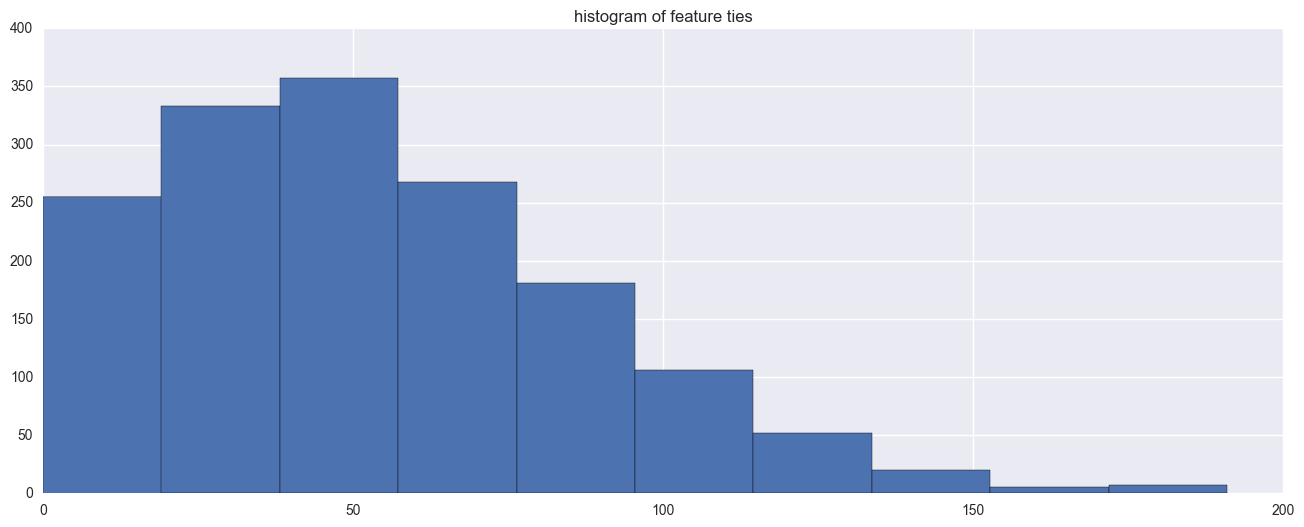

In [58]:
prepFeature("ties")

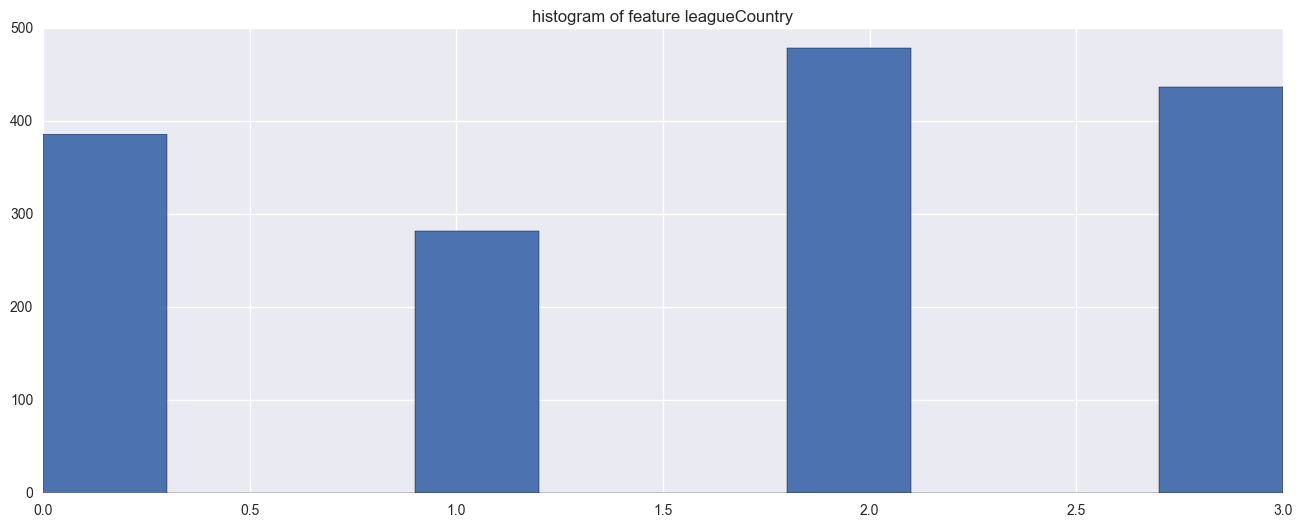

In [59]:
prepFeature("leagueCountry")

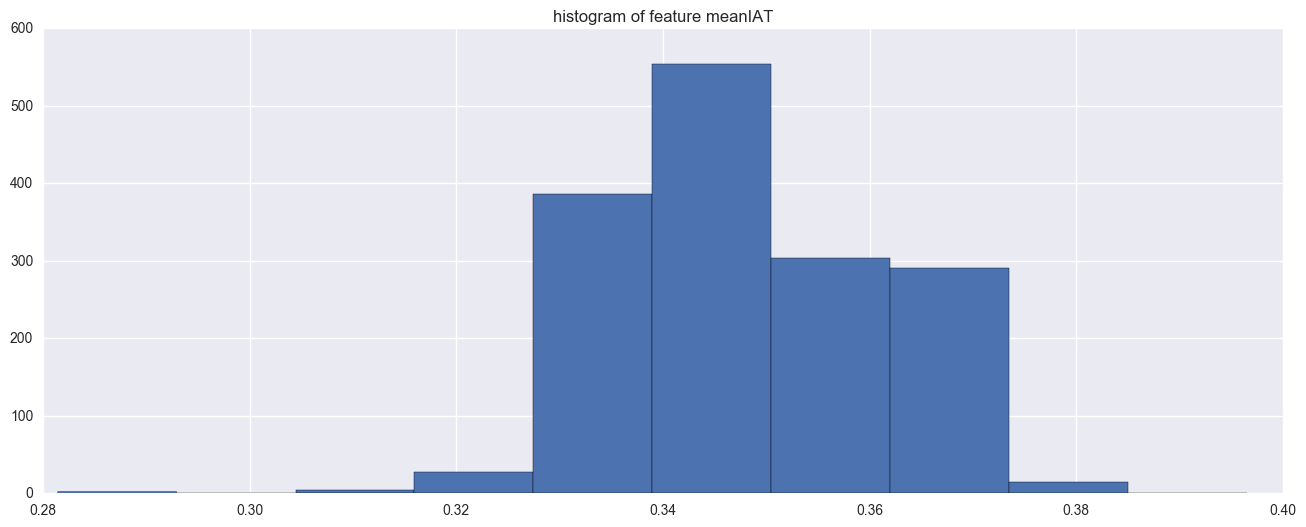

In [60]:
prepFeature("meanIAT")

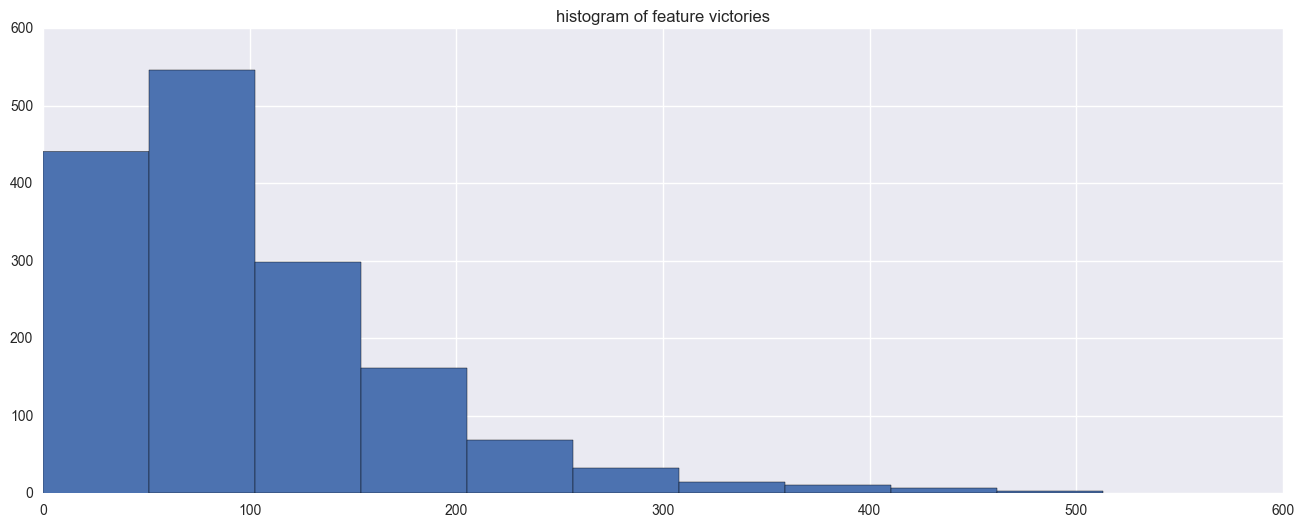

In [61]:
prepFeature("victories")

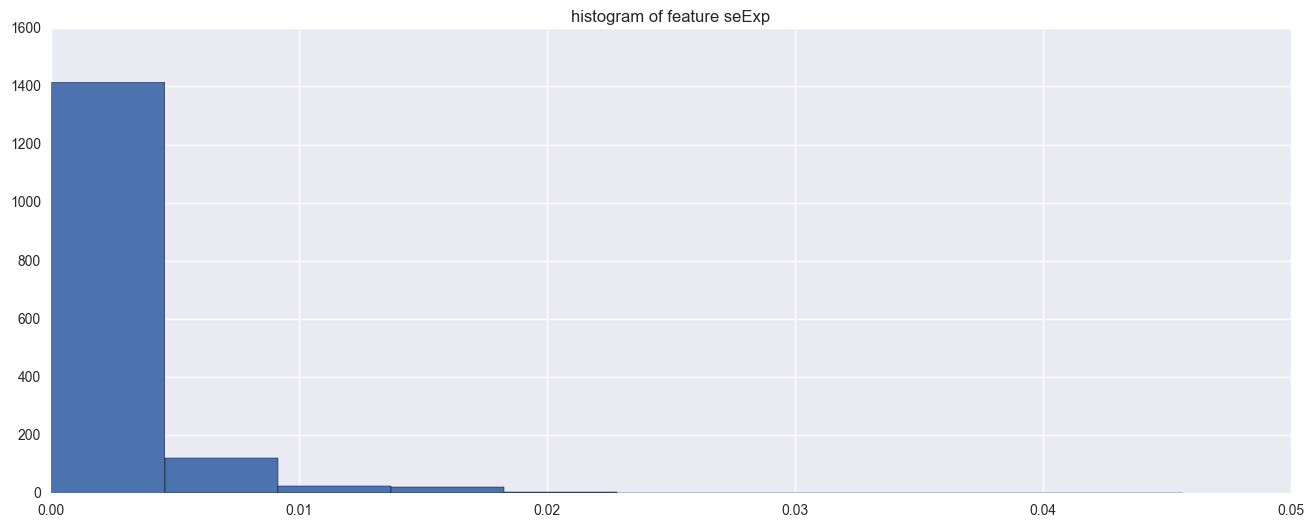

In [62]:
prepFeature("seExp")

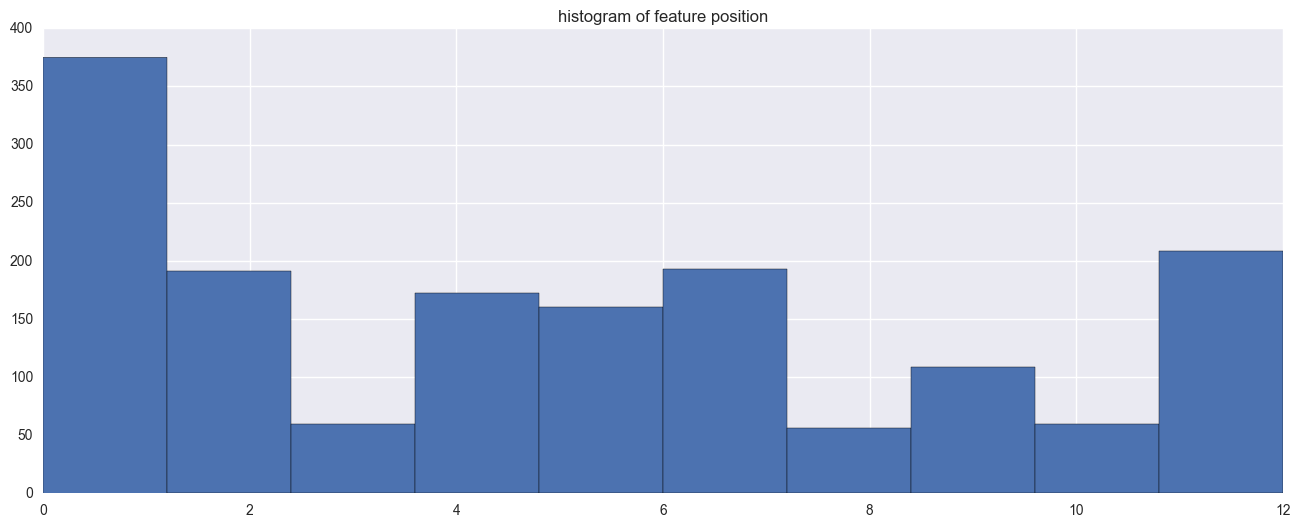

In [63]:
prepFeature("position")

## Naive machine learning

In [64]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

Let's build y (in a naive fashion for now).

In [65]:
y = ((y_possible['rater1'] + y_possible['rater2']) / 2 < 0.5).values

In [66]:
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [67]:
y_pred = rfc.predict(x)

In [68]:
print(metrics.mean_absolute_error(y, y_pred))
print(metrics.accuracy_score(y, y_pred))

0.00631313131313
0.993686868687


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Overfitting seems to be high without validating.

## Correct validation

Let's first split the dataset into a training and testing set. This seems to be generally a good practice in machine learning :).

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [70]:
rfc = RFC(n_estimators=10, class_weight=None)

In [71]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [72]:
y_pred = rfc.predict(x_test)

In [73]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.214511041009
0.785488958991


/usr/local/lib/python3.5/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Ok that's kind of disapointing... (but not so much suprising). A better way to show the error is cross validation.

In [74]:
# Cross validation 10-Fold (for now) with accuracy scoring
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')

In [75]:
def show_score(scores):
    print(scores)
    print("--------------------------")
    print("mean :", np.mean(scores))
    print("min :", np.min(scores))
    print("max :", np.max(scores))

show_score(scores)

[ 0.77987421  0.77987421  0.78616352  0.73584906  0.78616352  0.76582278
  0.78481013  0.7721519   0.7721519   0.75159236]
--------------------------
mean : 0.771445359385
min : 0.735849056604
max : 0.786163522013


We can see again that the result is not pretty, the mean result we have is ~76% which is not much better than perdicting that all players are light skinned.

Proportions of classes for the mean rating (considering 1 -> $mean \leq 0.5$).

In [76]:
# Proportion of light and dark skinned players
prop_1 = np.sum(y) / len(y)
prop_0 = 1 - prop_1
print("proportion of ones :", prop_1)
print("proportion of zeroes :", prop_0)

proportion of ones : 0.756944444444
proportion of zeroes : 0.243055555556


Let's look at what the confusion matrix has to say.

In [77]:
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
TP = confusion_mx[1, 1]
TN = confusion_mx[0, 0]
FP = confusion_mx[0, 1]
FN = confusion_mx[1, 0]

In [78]:
confusion_mx

array([[ 25,  51],
       [ 17, 224]])

Depending on the tree we got approximatively:

|total : 317| pred : 0 |  pred : 1  |
|---|----|-----|
| actual : 0 | TN = ~30 | FP = ~50 |
| actual : 1 | FN = ~30 | TP = ~200 |

We can see here that we are good at predicting ones, but our predictions of 0 are all over the place.

There is an easy way to show this : the **Specificity** (or how correct is the classifier with 0 values)

In [79]:
specificity = TN / float(TN + FP)
print("Specificity :", specificity)

Specificity : 0.328947368421


We can compare it to **Sensitivity** (or true positive rate)

In [80]:
sensitivity = TP / float(TP + FN)
print("Sensitivity :", sensitivity)

Sensitivity : 0.929460580913


Which is much better. 

All these methods are taken from the course and inspired from this [notebook](http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb).

So, how are we going to do a better job ?

The first thing we realize is that there is a way to indicate to the random forest classifier the fact that there is a disparity within the data.

In [81]:
class_weights = {
    1 : prop_1,
    0 : prop_0
}

In [82]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=class_weights)

We will use a function that prints out most of the information we used above to test our new rfc 

In [83]:
from helpers import test_rfc
test_rfc(rfc, x, y)

Cross validation scores
[ 0.75394322  0.71293375  0.74132492  0.75394322  0.79113924]
--------------------------
cross mean : 0.750656870183
cross min : 0.712933753943
cross max : 0.791139240506
----------
TP : 213
TN : 26
FP : 50
FN : 28
----------
specificity : 0.342105263158
sensitivity : 0.883817427386


Ok, to bad it's not better than before.

Let's try something else : changing the classification threshold

We think this will help the **specificity** get higher.

Let's retrain our data with our new rfc (with weights)

In [84]:
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

Getting the probability of ones of the classifier

In [85]:
y_pred_prob = rfc.predict_proba(x_test)[:, 1]

Separating the probability of true and false values

In [86]:
y_pred_prob1 = [x[1] for x in zip(y_test, y_pred_prob) if x[0]]
y_pred_prob0 = [x[1] for x in zip(y_test, y_pred_prob) if not x[0]]

The following graph was inspired by this video :

https://www.youtube.com/watch?v=OAl6eAyP-yo

It shows in blue the probability given to the true 0 values and in red the probability of true 1 values.

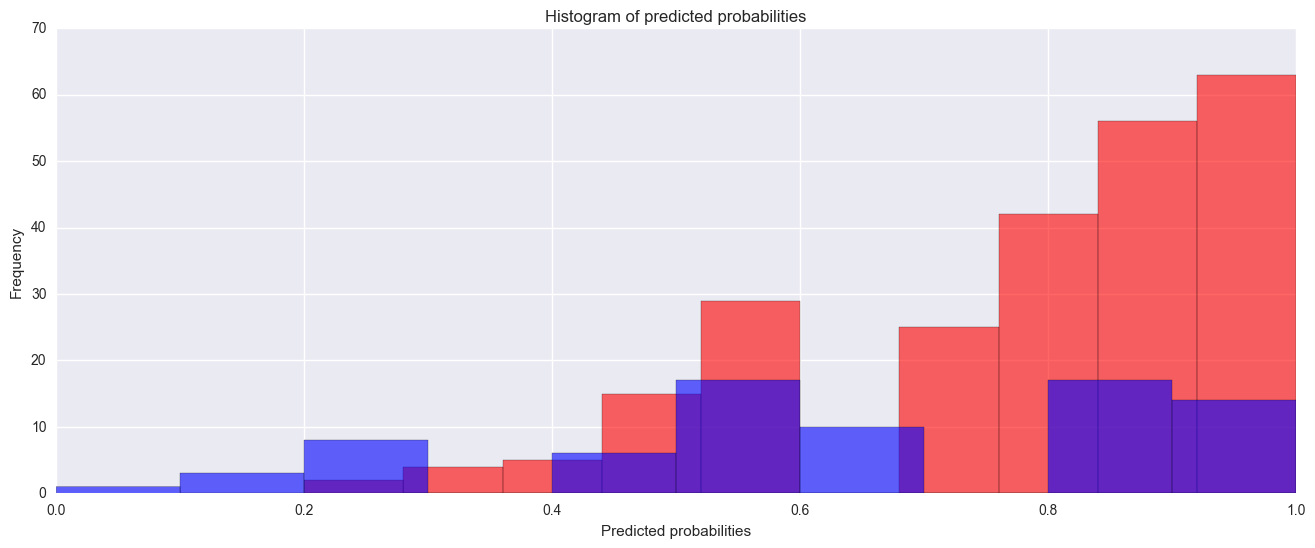

In [87]:
# histogram of predicted probabilities
plt.hist(y_pred_prob1, bins=10, alpha=0.6, color="red")
plt.hist(y_pred_prob0, bins=10, alpha=0.6, color="blue")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities')
plt.ylabel('Frequency')

With this graph we realized that it's going to be very difficult to have a good and fair (in terms of specificity and sensitivity) 

To verify this fact we are going to use the ROC curve and the AUC (Area Under the Curve) metric

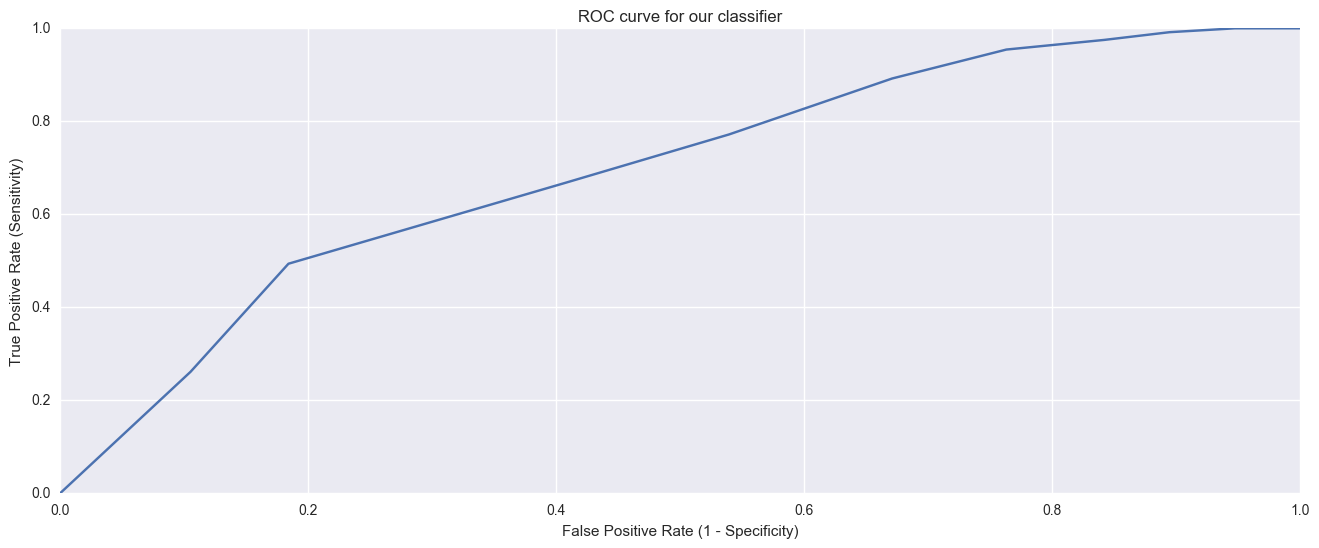

In [88]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.title('ROC curve for our classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [89]:
# calculate cross-validated AUC score
AUC_mean = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc').mean()
print("AUC score :", AUC_mean)

AUC score : 0.701566356975


Ok, so what does this all mean.

First the ROC curve shows us what are the best compromises we can make between Specificity and Sensitivity (be aware that here specificity is inversed), with that you could chose precisely what you want the classifier to be compromising.

For the AUC score it shows a score of our model compared to a random sampling of 1's and 0's. (PS. the random sample is weighted of course)

Ok now we have all the tools to try and accuratly validate a method

Cross validation scores
[ 0.74842767  0.73584906  0.74213836  0.72955975  0.71069182  0.7278481
  0.74050633  0.76582278  0.8164557   0.8089172 ]
--------------------------
cross mean : 0.752621677551
cross min : 0.710691823899
cross max : 0.816455696203
----------
TN : 29 FP : 47
FN : 30 TP : 211
----------
specificity : 0.381578947368
sensitivity or recall : 0.875518672199
precision : 0.817829457364


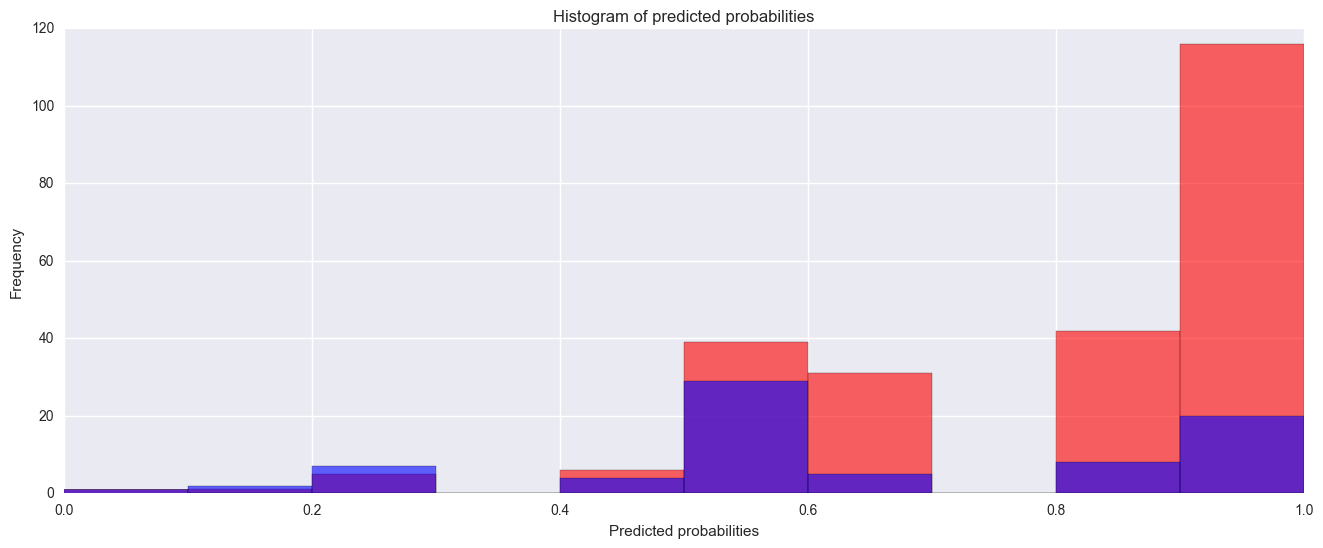

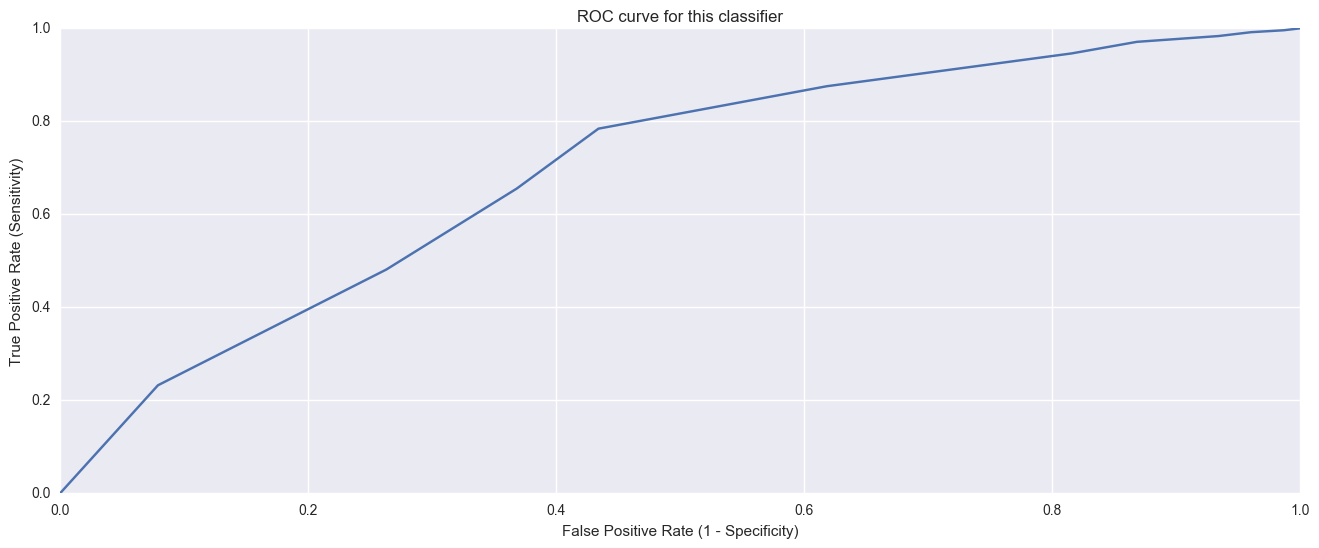

AUC score : 0.706151386668
f1 score : 0.706151386668


In [90]:
test_rfc_complete(rfc, x, y)

## Modifying the model

In this part we try to modify our model to have better result.

We have a lot of parameter to test for the random classifier, we selected two of them we think could change the results of the model.
 
The parameters we will test : 
  - n_estimators
  - max_features

In [91]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [92]:
n_estimators_range = list(range(10,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [93]:
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x117dad128>},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [94]:
rand.best_params_

{'max_features': 0.089821037737606857, 'n_estimators': 37}

In [95]:
rand.best_score_

0.73047106366572312

In [96]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]

Cross validation scores
[ 0.76100629  0.79874214  0.75471698  0.76100629  0.80503145  0.81012658
  0.8164557   0.77848101  0.79746835  0.77707006]
--------------------------
cross mean : 0.786010485392
cross min : 0.754716981132
cross max : 0.816455696203
----------
TN : 18 FP : 58
FN : 7 TP : 234
----------
specificity : 0.236842105263
sensitivity or recall : 0.970954356846
precision : 0.801369863014


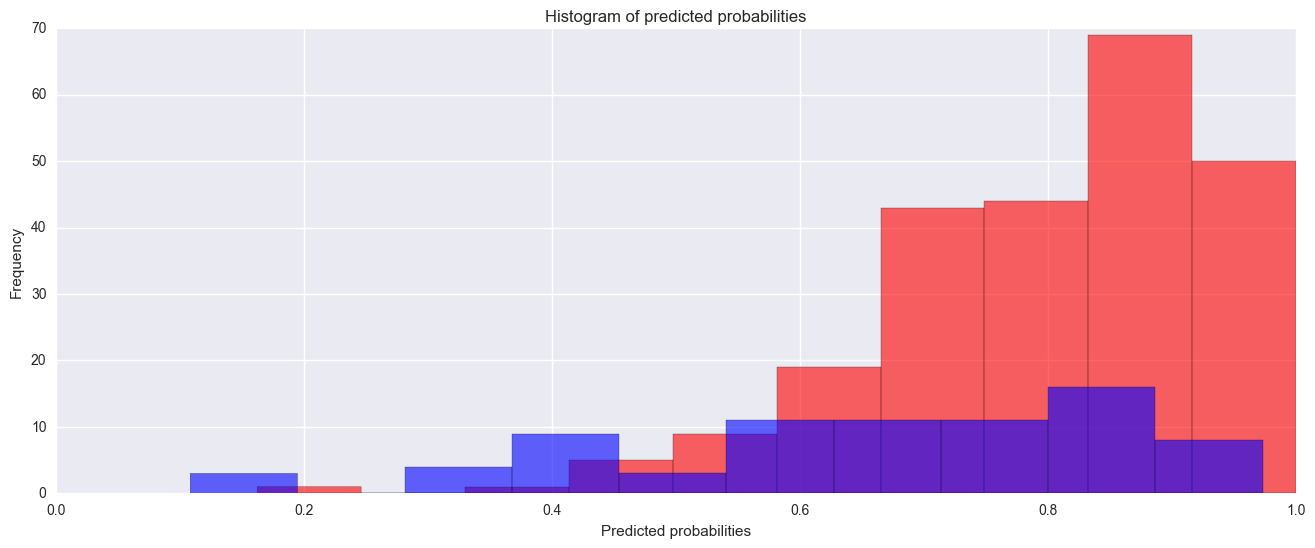

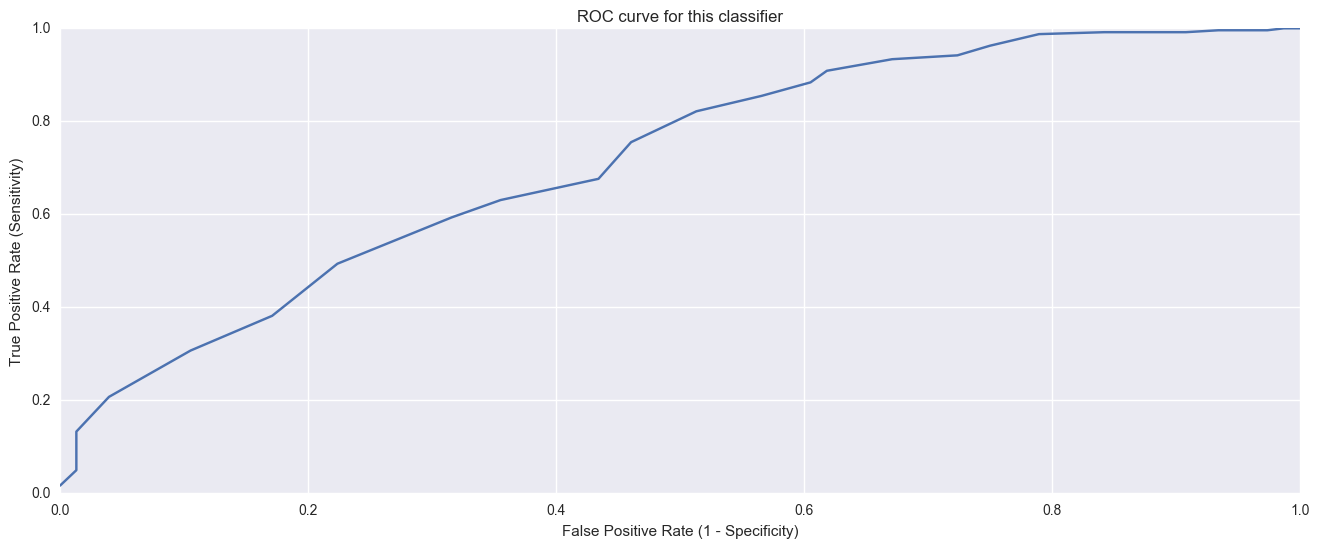

AUC score : 0.725377522804
f1 score : 0.725377522804


In [97]:
test_rfc_complete(RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights), x, y)

We should have with this method the best AUC score we could have. Which is still not really an improvement... (we will reuse this method later)

## Raters changes

As we said earlier in this notebook there are some things we can tune with the raters data we have. As we know the two raters have the following specificities :
- they rate differently
- they have values [0,0.25,0.5,0.75,1]

There are a few things we want to test : 
- a class for each possible value of the raters
- a class for < 0.5, > 0.5 and 0.5
- an independent learning for both raters
- only keeping the values where rater 1 and 2 are identical

We will test some different mix below

### A cluster for each value with independent raters

Here we will try predicting the 5 possible classes for one of the raters.

In [98]:
y_1 = (y_possible['rater1']).values

In [100]:
le = LabelEncoder()
le.fit(np.unique(y_1))
y_1 = le.transform(y_1)
y_1

array([1, 0, 1, ..., 3, 0, 0])

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y_1, test_size=0.2, random_state=4)

We use the best parameters we found before (they may need a twist later as the model changes)

In [102]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [103]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.089821037737606857,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
y_pred = rfc.predict(x_test)

In [105]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.79245283  0.82389937  0.7672956   0.75471698  0.79245283  0.79746835
  0.80379747  0.79113924  0.80379747  0.77707006]
--------------------------
mean : 0.79040902054
min : 0.754716981132
max : 0.823899371069


For this method we decided to not go further as it is difficultly testable and the following method gave kind of similar results

In [106]:
metrics.confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[94, 31,  0,  1,  0],
       [55, 51,  0,  1,  0],
       [29, 12,  0,  1,  0],
       [15,  7,  1,  4,  2],
       [ 5,  5,  0,  3,  0]])

We will not make an emphasis on this but here is the confusion matrix.

### 3 classes for values with a twist on the raters values

Let's look a bit more at the raters :

In [107]:
diff = [x[0] - x[1] for x in zip((y_possible['rater2']).values,(y_possible['rater1']).values) if not x[0] == x[1]]

In [108]:
diff = np.abs(diff)

In [109]:
np.unique(diff, return_counts=True)

(array([ 0.25,  0.5 ]), array([377,   2]))

We can see above that there are only small differences and 2 times where the difference is 0.5

With that we thought of doing this :
 - each time both raters are under 0.5 we put it in group 0
 - each time both raters are above 0.5 we put it in group 1
 - each time one rater is at 0.5 we look if the other falls in 0 or 1 and select that value
 - if both rating are 0.5 we put it in group 2
 - if both rating are between < 0.5 and > 0.5 we put it in group 3 

In [110]:
y_2 = []
for rate1, rate2 in zip((y_possible['rater2']).values,(y_possible['rater1']).values):
    if ((rate1 <= 0.5 and rate2 < 0.5) or (rate1 < 0.5 and rate2 <= 0.5)):
        y_2.append(1)
    elif ((rate1 >= 0.5 and rate2 > 0.5) or (rate1 > 0.5 and rate2 >= 0.5)):
        y_2.append(0)
    elif (rate1 == 0.5 or rate2 == 0.5):
        y_2.append(2)
    else :
        y_2.append(3)

In [111]:
np.unique(y_2, return_counts=True)

(array([0, 1, 2]), array([ 269, 1199,  116]))

We see here that the third group actually is never selected.

In [112]:
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

We use the best parameters we found before.

In [113]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [114]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.77987421  0.81761006  0.75471698  0.76100629  0.79245283  0.78481013
  0.79113924  0.80379747  0.79746835  0.78343949]
--------------------------
mean : 0.786631505768
min : 0.754716981132
max : 0.817610062893


Here accuracy has not changed from before. Let's look at the confusion matrix.

In [115]:
# Prep of training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

In [116]:
# Do prediction for test values
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [117]:
# Let's compute the convolution matrix
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
confusion_mx

array([[ 11,  39,   0],
       [  2, 239,   0],
       [  2,  24,   0]])

With the confusion matrix, the first problem we see is that their was **no prediction for the class 2** (there may be a few if you rerun the code). The second is that there is a lot false positive and the actual sensitivity is :

In [118]:
confusion_mx[1,1] / (confusion_mx[0,1]  + confusion_mx[1,1] +confusion_mx[2,1])

0.79139072847682124

Which is worse than what we had before.

### last solution, change the threshold position

The intuition for this change is that we know that our classifier is better at predicting "lighter" players, therefore increasing the considered "light" players we should get better results in terms of accuracy. 

In [119]:
y_3 = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x, y_3, test_size=0.2, random_state=4)

We know this is the best result we have, so let's find the best parameters we can.

In [121]:
prop1 = np.sum(y_3) / len(y_3)
prop0 = 1 - prop_1
class_weights = {
    0 : prop0,
    1 : prop1
}

In [122]:
prop1

0.83017676767676762

In [123]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [124]:
n_estimators_range = list(range(20,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [125]:
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(x, y_3)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.83017676767676762},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x117e00710>},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [126]:
#removed as not relevant even if there are useful informations for us
rand.cv_results_

{'mean_fit_time': array([ 0.13447208,  0.25683382,  0.20669551,  0.18407834,  0.12771449,
         0.2381731 ,  0.13334773,  0.17185419,  0.13429425,  0.13640561]),
 'mean_score_time': array([ 0.10643399,  0.1082819 ,  0.10589182,  0.10598853,  0.10738432,
         0.10763121,  0.10699553,  0.10585749,  0.10695443,  0.10599208]),
 'mean_test_score': array([ 0.76413598,  0.76005257,  0.73572365,  0.77283114,  0.75659434,
         0.7443327 ,  0.75688607,  0.74728868,  0.76483005,  0.76596648]),
 'mean_train_score': array([ 0.9999993 ,  0.99999983,  0.9999735 ,  0.99999791,  0.99999267,
         0.99999372,  0.99999948,  0.99999319,  1.        ,  1.        ]),
 'param_max_features': masked_array(data = [0.22199317108973948 0.83132783477544148 0.97944499916144601
  0.61174386290264571 0.51841798787294324 0.99082093080670552
  0.080741268764874863 0.81947279305241416 0.15830986771265121
  0.11090076173906371],
              mask = [False False False False False False False False False Fals

In [127]:
rand.best_params_

{'max_features': 0.61174386290264571, 'n_estimators': 36}

In [128]:
rand.best_score_

0.77283113965840566

In [129]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]

In [130]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

Cross validation scores
[ 0.82389937  0.88050314  0.8490566   0.79245283  0.88050314  0.83544304
  0.85443038  0.82278481  0.84810127  0.8343949 ]
--------------------------
cross mean : 0.842156949247
cross min : 0.792452830189
cross max : 0.880503144654
----------
TN : 12 FP : 38
FN : 6 TP : 261
----------
specificity : 0.24
sensitivity or recall : 0.977528089888
precision : 0.872909698997


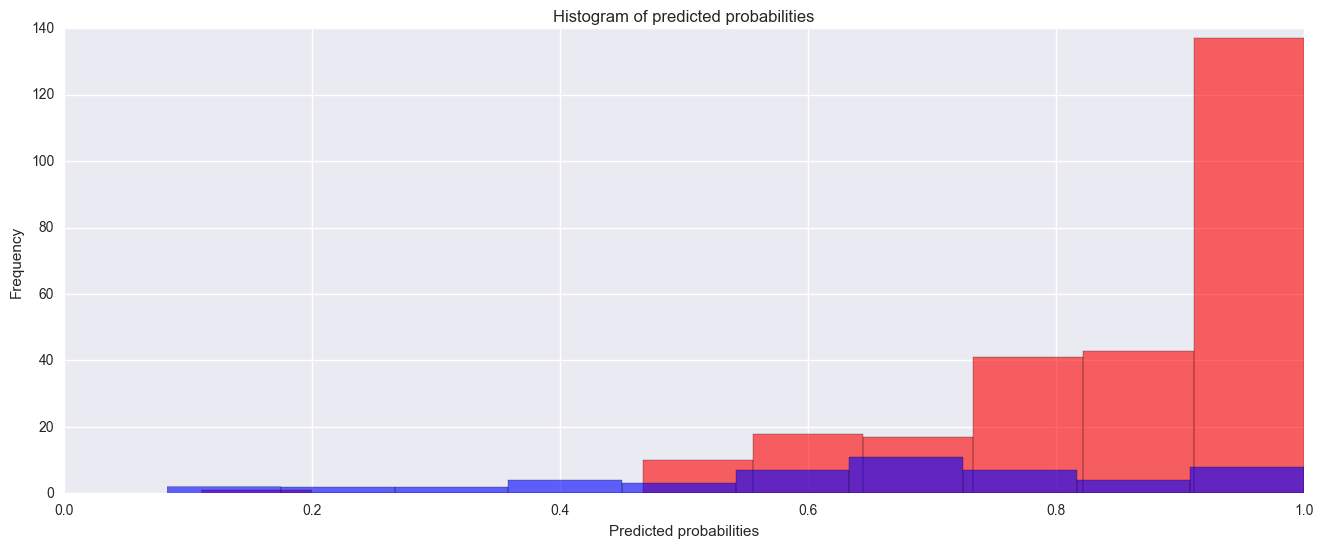

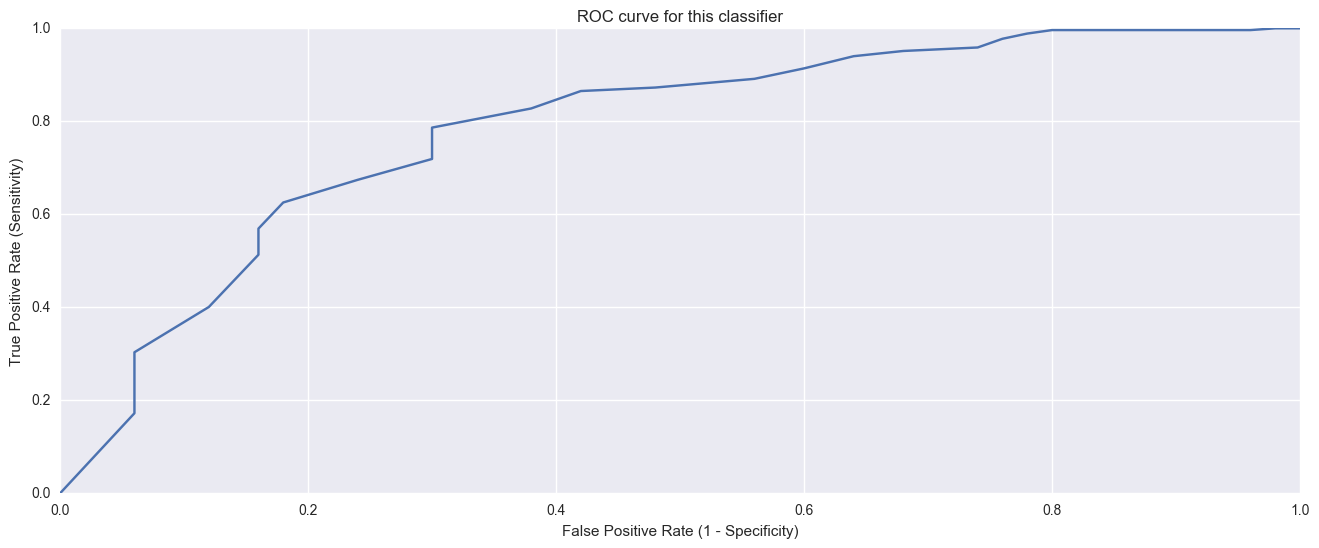

AUC score : 0.764871005679
f1 score : 0.764871005679


In [131]:
test_rfc_complete(rfc, x, y_3)

Ok here we have it, the best result we had so far. The AUC score is higher than ever before (~76%) ! With an accuracy of 84% we are also above all previously done tests. But if we look at specificity, it's not really better than before. but knowing the AUC score we know we can find good compromises between the two. 

## Learning curves

As we were asked let's show the learning curves for our best estimator

In [132]:
y = y_3

In [133]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

In [134]:
train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

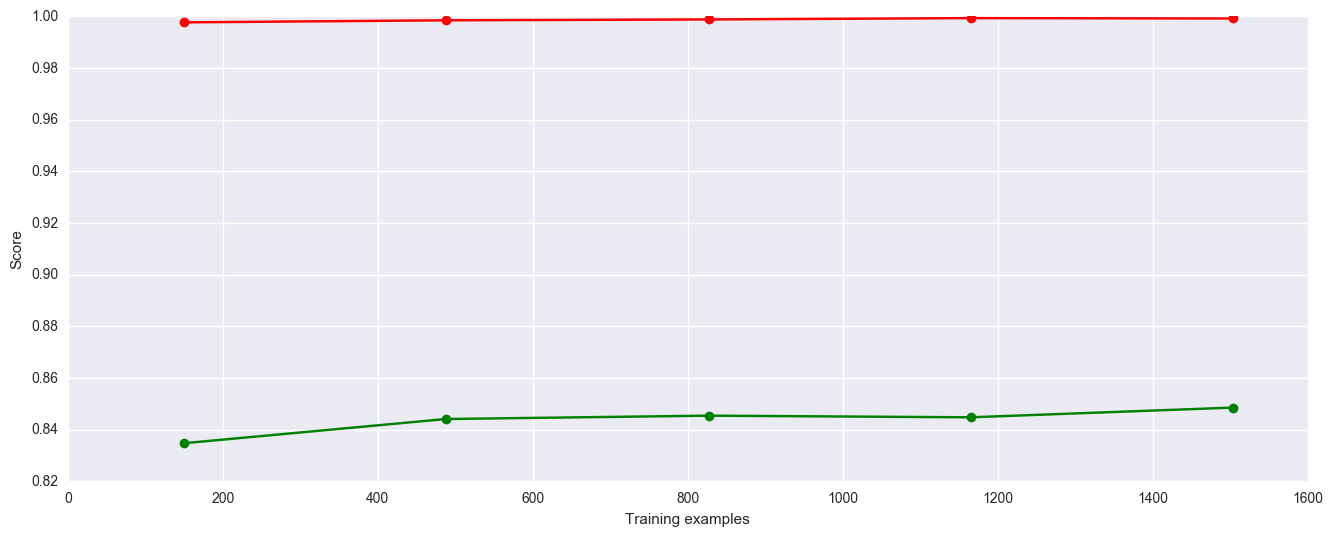

In [135]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

Let's know do the same thing for other parameters :

(0, 1)

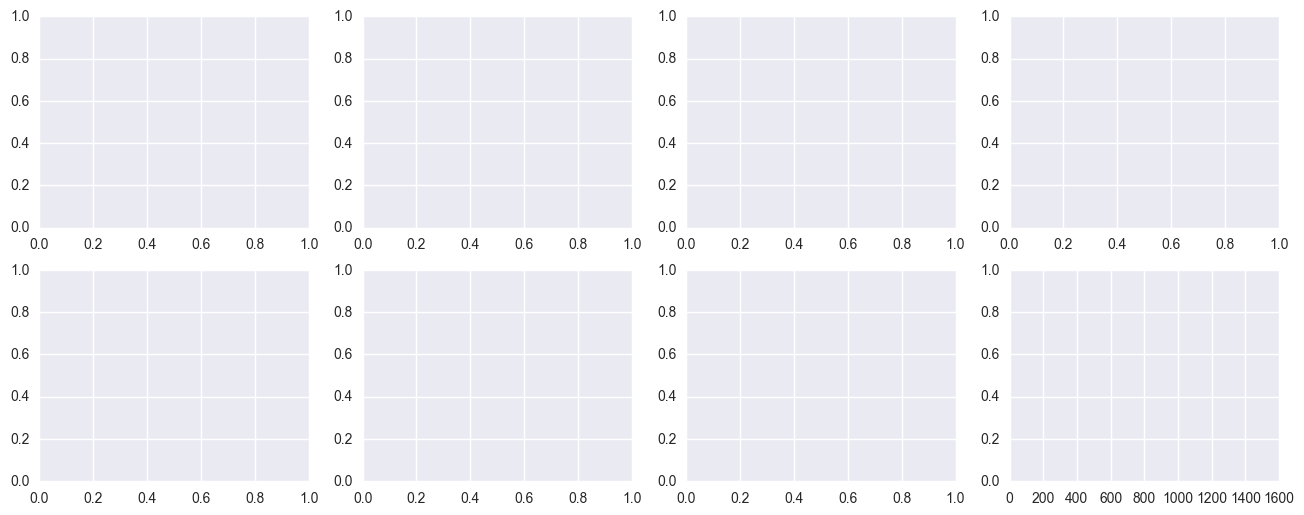

In [136]:
fig, axes = plt.subplots(2,4)

plt.xlim([0,1600])
plt.ylim([0,1])

In [ ]:
for i,n_estimators in enumerate(range(1, 40, 5)):
    rfc = RFC(max_features=max_features_b, n_estimators=n_estimators, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    curr_axis = axis[i % 2, i//4]
    
    curr_axis.set_xlabel("Training examples")
    curr_axis.set_ylabel("Score")
    curr_axis.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    curr_axis.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")


# Conclusion

Of course The last results we have are still not as good as we had hoped. We think this must come from the fact that we have to little information for this problem.